**Project Title:-** **Intelligent Handwriting Recognition Using Deep Neural Networks**

**Introduction:**

Handwriting recognition is a critical area of research in computer vision and artificial intelligence, aimed at automatically converting handwritten text into machine-readable digital formats. With the increasing need for digitizing documents, forms, and historical archives, accurate handwriting recognition systems can save significant time and resources compared to manual transcription. This project focuses on building deep learning–based models to recognize and transcribe handwritten words from scanned images. By leveraging CNNs, recurrent layers, and CTC loss, the system learns to handle varying handwriting styles, word lengths, and image qualities, providing a robust solution for real-world applications.

**Problem Statement:-**

Manual transcription of handwritten documents is labor-intensive, time-consuming, and prone to errors. Traditional OCR (Optical Character Recognition) systems often struggle with handwritten text due to inconsistencies in character shapes, spacing, and alignment. The problem, therefore, is to develop an automated system capable of accurately recognizing handwritten words from scanned images, reducing human effort while maintaining high precision and reliability.

**Business Problem:**

Organizations and institutions, such as banks, healthcare providers, educational institutions, and government offices, often deal with large volumes of handwritten forms, historical records, and applications. Inefficient processing of these documents can lead to delays, errors, and high operational costs. Implementing an accurate handwriting recognition system can automate document processing, improve data accessibility, reduce human error, and save significant time and cost. This project addresses the need for an intelligent solution to efficiently digitize handwritten text while supporting large-scale business operations.

**Data Collection:**

This code downloads and prepares the IAM Words dataset for a handwriting recognition project. It begins by fetching the dataset ZIP file from a GitHub release and quietly unzipping it. Afterward, it creates a structured folder system to store the extracted data. The script then unpacks the words.tgz archive into a dedicated directory and moves the corresponding words.txt metadata file into the main data folder. Overall, this setup ensures that the handwriting image files and their annotations are properly organized and ready for further processing or model training.

In [9]:
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [10]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


**Import and setup:**

This code initializes the environment for a handwriting recognition project by importing essential libraries such as Keras, TensorFlow, NumPy, Matplotlib, and OS utilities. It includes modules like StringLookup for text processing and ops for tensor operations. To ensure reproducibility, the script sets fixed random seeds for both NumPy and Keras, so that model training and data-related operations produce consistent results across runs. This setup forms the foundation for building, training, and evaluating deep learning models in a stable and controlled manner.

In [11]:
import keras
from keras.layers import StringLookup
from keras import ops
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
keras.utils.set_random_seed(42)

**Processing the IAM Words Dataset**

This code loads and processes the words.txt annotation file from the IAM handwriting dataset. It begins by defining the base data directory and reading all lines from the annotation file. Any line starting with # is skipped since these are comments or metadata. The script also filters out entries marked as "err" to avoid samples with errors. Valid entries are stored in a list, and the total number of usable word samples is determined. Finally, the list is shuffled using NumPy to ensure randomness during training and dataset preparation.

In [12]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

**Splitting the Dataset into Training, Validation, and Test Sets**

This code divides the cleaned list of word samples into three subsets for model development. First, 90% of the data is allocated to the training set, ensuring the model has sufficient examples to learn from. The remaining 10% is split evenly into validation and test sets, where the validation set helps tune model performance during training and the test set is used for final evaluation. An assertion confirms that no samples were lost during the split. Finally, the script prints the total number of samples in each subset, providing a quick overview of the dataset distribution.

In [13]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


**Extracting Image Paths and Corresponding Labels:**

This section defines a function that maps each annotation line to its correct image file within the IAM dataset. Each sample contains an encoded image identifier (e.g., part1-part2-part3), which is used to reconstruct the full file path following the dataset’s folder structure. The code splits each annotation line, identifies the image name, and builds the correct directory path using the partI/partI-partII/filename.png format. Before accepting the file, it checks whether the image actually exists and is non-empty. Valid image paths and their associated labels are collected and returned. Finally, the function is applied to generate organized image paths and labels for the training, validation, and test sets.

In [14]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for i, file_line in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

**Building the Character Vocabulary and Determining Label Properties**

This part of the code processes the training labels to prepare them for model training. It begins by extracting only the actual word (label) from each annotation line and collects every unique character that appears in the dataset. As it iterates through all labels, it also tracks the maximum word length, which is essential for setting input sequence sizes in sequence models like RNNs or CTCLoss-based architectures. Each cleaned label is stored for later use. After processing all samples, the code prints the maximum label length and the total number of unique characters—representing the vocabulary size. Finally, it displays the first few cleaned labels as a quick verification step.

In [15]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

**Cleaning Validation and Test Labels for Processing:**

This function standardizes the label extraction process by isolating the actual word from each annotation line. Each label line contains metadata followed by the target word at the end, so the function splits the line and retains only the last element. It trims any extra whitespace and stores the cleaned word in a new list. The same cleaning process is then applied to both the validation and test label sets, ensuring that all labels across the dataset follow a consistent and model-ready format.

In [16]:

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

**Creating Character–Integer Mappings for Model Encoding**

This section prepares the character-level encoding required for training a handwriting recognition model. Using TensorFlow’s StringLookup layer, it first creates a character-to-integer mapping (char_to_num) based on the sorted list of unique characters extracted from the training labels. This converts each character in a word into a numerical representation suitable for neural networks. Then, an inverse mapping (num_to_char) is created so that model predictions—generated as integer sequences—can be converted back into readable characters. Together, these lookup layers form the core of the text-processing pipeline used during both training and inference.

In [17]:

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

**Resizing Images Without Distortion (Aspect Ratio Preservation)**

This function performs distortion-free resizing on handwriting images while keeping their aspect ratio intact. It first scales the image to fit within a target size using tf.image.resize with aspect-ratio preservation enabled. Because this resizing may leave empty space, the function calculates the exact amount of padding needed on each side to reach the desired height and width. It then applies symmetric padding—adjusting for odd values when necessary—to ensure the image remains centered. After padding, the image is transposed and horizontally flipped to match the expected input orientation for the handwriting recognition model. The final output is a consistently sized, distortion-free image suitable for training.

In [18]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - ops.shape(image)[0]
    pad_width = w - ops.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = ops.transpose(image, (1, 0, 2))
    image = tf.image.flip_left_right(image)
    return image


**Building the Preprocessing Pipeline for Images and Labels:**

This section defines the complete preprocessing workflow required to prepare images and labels for training a handwriting recognition model. It begins by setting core configuration values such as batch size, padding token, and target image dimensions. The preprocess_image() function loads each PNG image, decodes it in grayscale, applies distortion-free resizing, and normalizes pixel values to the range [0, 1]. The vectorize_label() function converts each word label into a sequence of integer-encoded characters using the earlier lookup table, then pads the sequence to a uniform maximum length using a special padding token. The process_images_labels() helper combines these two steps to generate a model-ready dictionary containing both the processed image and its encoded label. Finally, prepare_dataset() creates a TensorFlow dataset pipeline that loads image–label pairs, maps the preprocessing functions across all samples using parallel calls, batches them, caches them for efficiency, and prefetches data to optimize GPU/CPU utilization. This forms the backbone of an efficient and scalable input pipeline for training the OCR model.

In [19]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = ops.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = ops.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


**Creating TensorFlow Datasets for Training, Validation, and Testing**

This step generates the final TensorFlow datasets by applying the preprocessing pipeline to each dataset split. Using the previously defined prepare_dataset() function, the code converts the training, validation, and test image–label pairs into efficient tf.data.Dataset objects. Each dataset includes batched, cached, and prefetched samples, ensuring smooth and optimized data feeding during model training and evaluation. These prepared datasets are now ready to be used directly with the model’s fit(), evaluate(), and prediction workflows.

In [20]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

**Visualizing Sample Images and Their Decoded Labels**

This code retrieves a single batch from the training dataset and displays 16 sample images along with their corresponding word labels. For each image, the script reverses the earlier preprocessing steps by flipping it horizontally and transposing it back to its original orientation. The pixel values are then rescaled to an 8-bit grayscale format for proper display. To recover the label, the code filters out padding tokens, converts the remaining character indices back into text using num_to_char, and joins them into a readable word. Each image–label pair is plotted in a 4×4 grid using Matplotlib, providing a quick visual check to ensure that preprocessing, label encoding, and dataset construction are all functioning correctly.

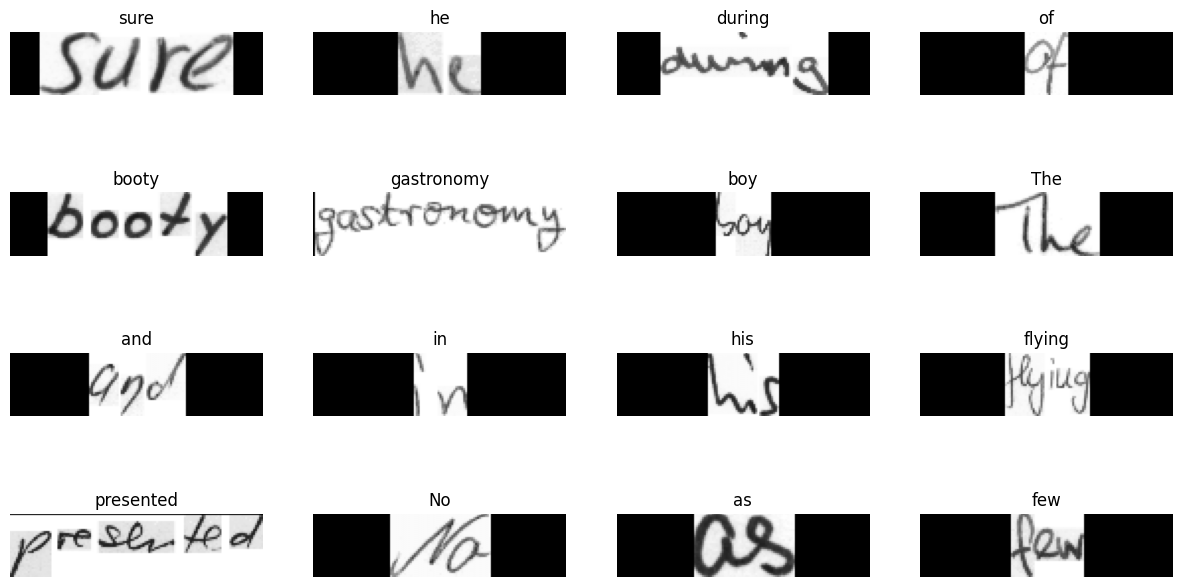

In [21]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = ops.transpose(img, (1, 0, 2))
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

**Building the Handwriting Recognition Model Using CNN, BiLSTM, and CTC Loss**

This section constructs the complete handwriting recognition model using a combination of convolutional layers, bidirectional LSTMs, and a custom CTC (Connectionist Temporal Classification) loss layer. The custom CTCLayer class wraps TensorFlow’s CTC loss function, calculating the loss dynamically during training based on predicted sequence lengths and label lengths. The build_model() function begins by defining two input streams—one for the processed image and one for the encoded label. It then applies two convolution–max pooling blocks to extract meaningful spatial features while reducing image dimensions. Afterward, the feature maps are reshaped and passed through a fully connected layer and dropout for regularization. The model then uses two bidirectional LSTM layers to capture temporal dependencies along the width of the image, enabling the network to interpret characters sequentially. A final dense layer outputs class probabilities over all characters, including extra CTC-specific tokens. The CTC layer is used to compute the loss directly during training, and the model is compiled with the Adam optimizer. Finally, model.summary() provides an overview of the architecture, confirming successful model creation.

In [32]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = ops.cast(ops.shape(y_true)[0], dtype="int64")
        input_length = ops.cast(ops.shape(y_pred)[1], dtype="int64")
        label_length = ops.cast(ops.shape(y_true)[1], dtype="int64")

        input_length = input_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt, jit_compile=False)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 32,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 32,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 16,    │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 64, 16,    │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 32, 8, 64) │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32, 512)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 32, 64)    │     32,832 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 32, 256)   │    197,632 │ dropout_4[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 32, 128)   │    164,352 │ bidirectional_6[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 32, 81)    │     10,449 │ bidirectional_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 32, 81)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 424,081 (1.62 MB)

 Trainable params: 424,081 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

Evaluation metric

In [23]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

**Calculating Edit Distance and Monitoring Model Performance During Training**

This block introduces a mechanism to evaluate how well the handwriting recognition model performs by measuring edit distance, an important metric for sequence prediction tasks. The calculate_edit_distance() function converts both true labels and predicted sequences into sparse tensor format, which is required for computing edit distance efficiently. It decodes the model’s CTC-formatted output using ctc_decode, trims predictions to the maximum label length, and computes the average edit distance between predicted sequences and ground-truth labels. To track this metric during training, the EditDistanceCallback class is defined as a custom Keras callback. At the end of each epoch, it uses the prediction model to generate outputs for the validation dataset, calculates edit distances for each batch, and prints the mean value. This provides an interpretable and direct measure of the model’s real-world text recognition accuracy, beyond loss values alone.

In [24]:

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = ops.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.ops.nn.ctc_decode(
        predictions, sequence_lengths=input_len
    )[0][0][:, :max_len]
    sparse_predictions = ops.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


**Training the Handwriting Recognition Model with Edit-Distance Monitoring**

This code initializes the full training process for the handwriting recognition model. It begins by rebuilding the model architecture and creating a separate prediction_model that outputs character probabilities before the CTC loss layer—necessary for decoding predictions during evaluation. The custom EditDistanceCallback is then instantiated to compute and display the mean edit distance after every epoch, providing a practical measure of how closely the model’s predictions match the true labels. The model is trained for 10 epochs using the prepared training and validation datasets, with the callback included to track performance improvements over time. The history object stores training and validation metrics for further visualization or analysis.

In [26]:
epochs = 10

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").output, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


**Decoding Model Predictions and Visualizing Test Results:**

This part of the code handles the inference stage by converting the model’s raw CTC outputs back into readable text. The decode_batch_predictions() function begins by defining the input sequence lengths and uses greedy CTC decoding to generate predicted character indices. It then filters out blank tokens, maps the indices back to characters using num_to_char, removes any unknown tokens, and assembles each sequence into a full word. After decoding, the script takes one batch from the test dataset and generates predictions through the prediction_model. It then displays 16 test images in a 4×4 grid, reversing earlier preprocessing steps (flipping and transposing the images) to restore correct orientation. Each subplot shows a grayscale handwritten word along with its predicted text, providing a clear visual evaluation of the model’s performance on unseen samples.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


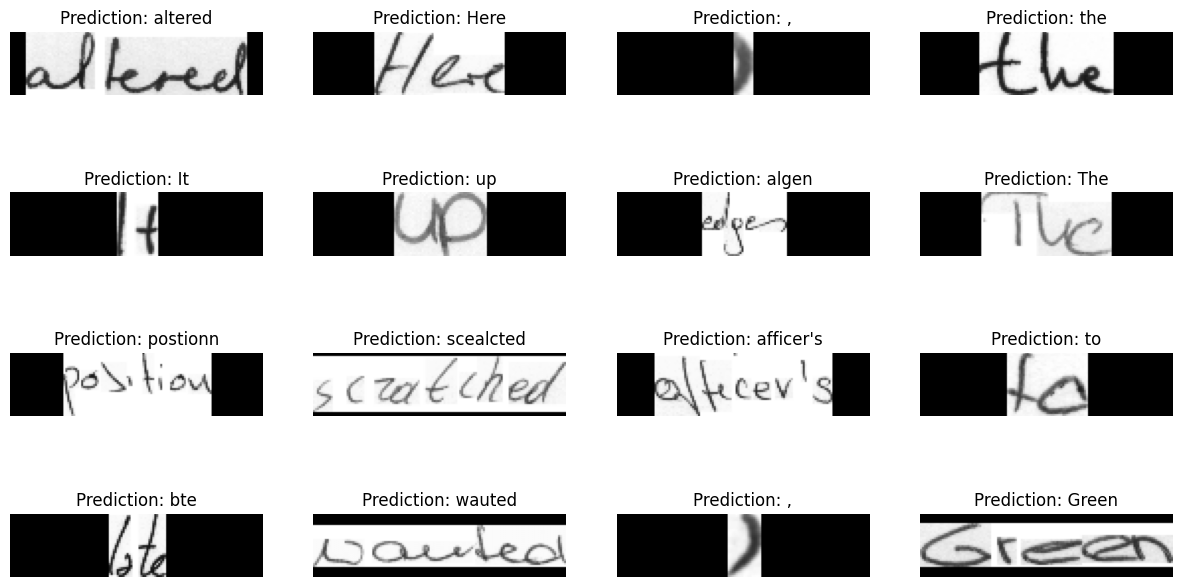

In [27]:

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.ops.nn.ctc_decode(pred, sequence_lengths=input_len)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = (
            tf.strings.reduce_join(num_to_char(res))
            .numpy()
            .decode("utf-8")
            .replace("[UNK]", "")
        )
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = ops.transpose(img, (1, 0, 2))
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

**Building Residual Convolutional Blocks for the Second OCR Model**

This section defines the core building components of a ResNet-style architecture to enhance feature extraction for handwriting recognition. The conv_block() function applies a convolution followed by batch normalization and ReLU activation, forming a standard building unit used throughout modern CNNs. The residual_block() function creates a two-layer residual unit that helps the network learn deeper representations without suffering from vanishing gradients. It supports optional downsampling (stride = 2) to reduce spatial dimensions while increasing semantic depth. If the input and output channel dimensions differ—or when downsampling is applied—the shortcut path is projected through a 1×1 convolution to match shapes. Finally, the block adds the shortcut connection to the processed features and applies a ReLU activation, forming a classic residual learning structure that improves gradient flow and model stability.

In [28]:
from keras import layers

def conv_block(x, filters, kernel_size=3, stride=1):
    """A simple conv -> BN -> ReLU block."""
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def residual_block(x, filters, downsample=False):
    """A basic residual block with optional downsampling (stride=2)."""
    stride = 2 if downsample else 1
    shortcut = x

    # 1st conv
    x = conv_block(x, filters, kernel_size=3, stride=stride)
    # 2nd conv (no activation)
    x = layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # shortcut projection if shape changes
    if downsample or int(shortcut.shape[-1]) != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

**Building a Lightweight ResNet-CTC OCR Model**

This model uses a compact ResNet-style architecture combined with CTC loss to recognize text sequences from images. Each residual_block() adds skip connections to help the network train deeper layers without vanishing gradients. All downsampling is disabled to maximize time-steps, which is essential for OCR models where the width of the feature map maps to the character sequence.

After stacking the residual blocks, the model collapses the height dimension to convert the feature map into a sequence format. A dense layer processes each time step, and a final softmax layer predicts character probabilities. The CTCLayer then computes the alignment-free sequence loss to train the model end-to-end. This architecture is optimized for handwriting recognition with strong temporal resolution.

In [33]:
from keras import layers

def residual_block(x, filters, downsample=False):
    """A basic residual block with optional downsampling (stride=2)."""
    stride = 2 if downsample else 1
    shortcut = x

    # 1st conv
    x = conv_block(x, filters, kernel_size=3, stride=stride)
    # 2nd conv (no activation)
    x = layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # shortcut projection if shape changes
    if downsample or int(shortcut.shape[-1]) != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet_ctc(input_shape=(image_width, image_height, 1), num_chars=None):
    """
    input_shape: (width, height, channels) — matches your pipeline
    num_chars: size of vocabulary (from char_to_num.get_vocabulary())
    """
    if num_chars is None:
        num_chars = len(char_to_num.get_vocabulary())

    input_img = keras.Input(shape=input_shape, name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # Stem
    x = layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False)(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="same")(x)

    # Residual stages: lightweight ResNet-like pattern
    x = residual_block(x, 64, downsample=False)
    x = residual_block(x, 64, downsample=False)

    # Changed downsample=True to downsample=False to increase time steps
    x = residual_block(x, 128, downsample=False)
    x = residual_block(x, 128, downsample=False)

    # Changed downsample=True to downsample=False to increase time steps
    x = residual_block(x, 256, downsample=False)
    x = residual_block(x, 256, downsample=False)

    # Changed downsample=True to downsample=False to increase time steps
    x = residual_block(x, 512, downsample=False)
    x = residual_block(x, 512, downsample=False)

    # Collapse height into channels so time dimension = width
    # x shape: (batch, new_w, new_h, channels)
    def collapse_height(t):
        # t: (batch, w, h, c) -> (batch, w, h*c)
        s = tf.shape(t)
        batch = s[0]
        w = s[1]
        h = s[2]
        c = s[3]
        t = tf.reshape(t, (batch, w, h * c))
        return t

    x = layers.Lambda(collapse_height, name="collapse_height")(x)  # (batch, time_steps, features)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    # Final per-time-step classifier (softmax)
    logits = layers.Dense(num_chars + 2, activation="softmax", name="dense2")(x)

    # CTC loss layer uses labels and logits
    output = CTCLayer(name="ctc_loss")(labels, logits)

    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="resnet_ctc")
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, jit_compile=False)
    return model

# Build model (num_chars from your StringLookup)
num_chars = len(char_to_num.get_vocabulary())
resnet_model = build_resnet_ctc(num_chars=num_chars)
resnet_model.summary()

# Prediction model for decoding (logits output)
prediction_model_resnet = keras.models.Model(
    resnet_model.get_layer(name="image").output,
    resnet_model.get_layer(name="dense2").output
)

print("Prediction model ready:", prediction_model_resnet)

Model: "resnet_ctc"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 32,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 16,    │      3,136 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 16,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 64, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 8, 64) │          0 │ re_lu_17[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 8, 64) │     36,864 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 8, 64) │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 32, 8, 64) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 8, 64) │     36,864 │ re_lu_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 8, 64) │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 32, 8, 64) │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 32, 8, 64) │          0 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 8, 64) │     36,864 │ re_lu_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 8, 64) │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 32, 8, 64) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 8, 64) │     36,864 │ re_lu_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 8, 64) │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 32, 8, 64) │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 32, 8, 64) │          0 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 12,249,489 (46.73 MB)

 Trainable params: 12,239,889 (46.69 MB)

 Non-trainable params: 9,600 (37.50 KB)

Prediction model ready: <Functional name=functional_3, built=True>


Training callbacks

In [30]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "resnet_ctc_best.h5", monitor="val_loss", save_best_only=True, save_weights_only=False
)
earlystop_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)


**Training the ResNet-CTC Model for Handwritten Text Recognition:**

This stage involves training a custom ResNet-based Convolutional Neural Network integrated with a CTC (Connectionist Temporal Classification) decoding layer to recognize handwritten text sequences. The model is trained using a dataset of labeled text images, where each sample includes an input image and its corresponding character sequence. During training, the network learns visual features through residual blocks and predicts character probabilities across time steps. The CTC loss enables the model to align predictions with variable-length text without requiring manual segmentation. The training process uses checkpointing to save the best model weights and early stopping to prevent overfitting, ensuring efficient and stable convergence over 10 epochs.

In [38]:
epochs = 10
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 293s 216ms/step - loss: 63.6244 - val_loss: 163.2865
Epoch 2/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 58.7716

1357/1357 ━━━━━━━━━━━━━━━━━━━━ 289s 213ms/step - loss: 58.7696 - val_loss: 124.7529
Epoch 3/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 288s 212ms/step - loss: 49.1539 - val_loss: 196.7859
Epoch 4/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 289s 213ms/step - loss: 45.1847 - val_loss: 198.1100
Epoch 5/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 311s 230ms/step - loss: 41.3366 - val_loss: 141.4016
Epoch 6/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 315s 232ms/step - loss: 36.5536 - val_loss: 147.1420
Epoch 7/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 296s 218ms/step - loss: 33.8351 - val_loss: 174.6065
Epoch 8/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 289s 213ms/step - loss: 30.5639 - val_loss: 143.2837
Epoch 9/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 290s 214ms/step - loss: 27.9993 - val_loss: 147.8457
Epoch 10/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 321s 213ms/step - loss: 25.3151 - val_loss: 166.4728


**Inference and Prediction Using the Trained ResNet-CTC Model:**

In this stage, the trained ResNet-CTC model is used to perform inference on unseen test images to evaluate the model’s real-world text recognition ability. A prediction model is first created by extracting the output logits of the final dense layer. These logits are then passed through a greedy CTC decoding function that converts the per-time-step character probabilities into readable text sequences. For visualization, a batch of test images is processed, decoded, and displayed in a 4×4 grid, where each image is shown alongside the predicted text. This step helps verify whether the model has learned consistent patterns during training and how accurately it generalizes to new data.

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step


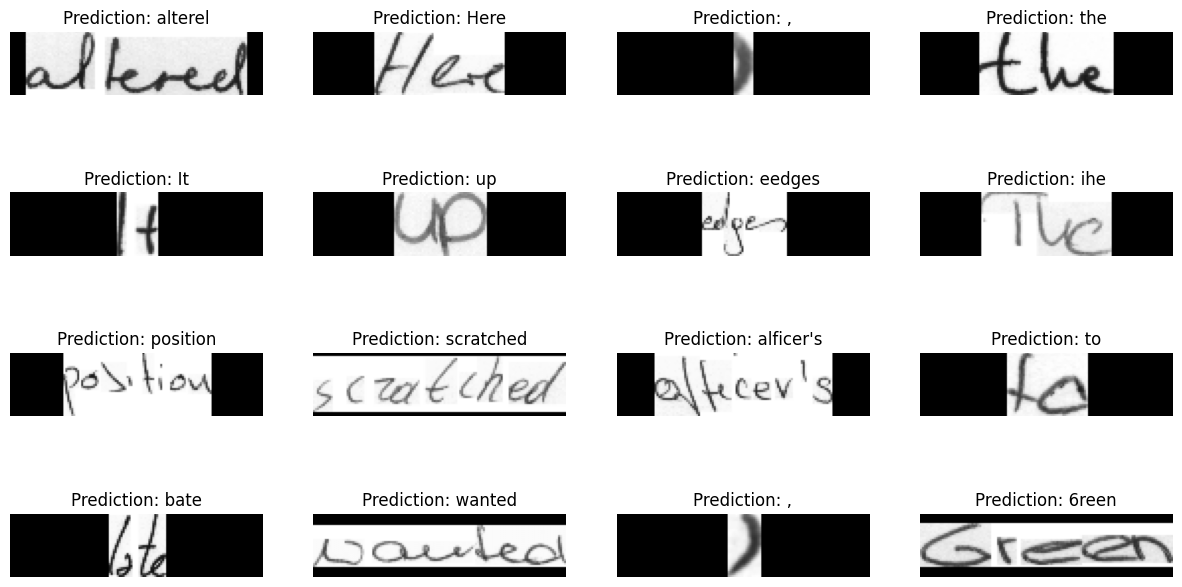

In [35]:

#  CREATE PREDICTION MODEL
prediction_resnet_model = keras.models.Model(
    resnet_model.get_layer(name="image").output,
    resnet_model.get_layer(name="dense2").output
)

# SAME DECODE FUNCTION
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    # Greedy CTC decode
    results = keras.ops.nn.ctc_decode(
        pred, sequence_lengths=input_len
    )[0][0][:, :max_len]

    output_text = []

    for res in results:
        # remove -1 values
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))

        # convert to string
        res = (
            tf.strings.reduce_join(num_to_char(res))
            .numpy()
            .decode("utf-8")
            .replace("[UNK]", "")
        )
        output_text.append(res)

    return output_text

# RUN INFERENCE ON TEST DATASET

for batch in test_ds.take(1):
    batch_images = batch["image"]

    # forward pass
    preds = prediction_resnet_model.predict(batch_images)

    # decode
    pred_texts = decode_batch_predictions(preds)

    # plot 16 samples
    fig, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = batch_images[i]

        # postprocessing to display properly
        img = tf.image.flip_left_right(img)
        img = ops.transpose(img, (1, 0, 2))
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(f"Prediction: {pred_texts[i]}")
        ax[i // 4, i % 4].axis("off")

plt.show()


**Extracting Model Predictions and Ground-Truth Labels for Evaluation:**

This function collects all predictions and corresponding ground-truth labels from the evaluation dataset to prepare them for downstream statistical analysis. For each batch of images, the ground-truth labels—stored as padded numeric sequences—are decoded back into readable text using the character lookup mapping. The model then generates logits for the images, which are decoded into predicted text strings using the CTC decoding mechanism. Both decoded predictions and true labels are accumulated across the full dataset and returned as NumPy arrays. These arrays provide the foundation for computing evaluation metrics such as the classification report and confusion matrix, enabling a detailed assessment of the model’s text recognition performance.

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

def get_all_predictions(model, dataset):
    all_preds = []
    all_labels = []

    for batch in dataset:
        images = batch["image"]
        labels = batch["label"]  # padded numeric labels but we need cleaned version

        # decode ground truth labels
        gt_texts = []
        for lbl in labels.numpy():
            text = ""
            for idx in lbl:
                if idx == padding_token:
                    break
                text += num_to_char(idx).numpy().decode("utf-8")
            gt_texts.append(text)

        preds = model.predict(images)
        pred_texts = decode_batch_predictions(preds)

        all_preds.extend(pred_texts)
        all_labels.extend(gt_texts)

    return np.array(all_labels), np.array(all_preds)


**Get predictions for both models**

In [40]:
y_true_1, y_pred_1 = get_all_predictions(prediction_model, test_ds)
y_true_2, y_pred_2 = get_all_predictions(prediction_model_resnet, test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━

**Convert sequences into character lists**

In [41]:
def flatten_char_sequences(y_true, y_pred):
    true_chars = []
    pred_chars = []

    for t, p in zip(y_true, y_pred):
        t_list = list(t)
        p_list = list(p)

        min_len = min(len(t_list), len(p_list))

        # compare only over aligned characters
        true_chars.extend(t_list[:min_len])
        pred_chars.extend(p_list[:min_len])

    return np.array(true_chars), np.array(pred_chars)


**Flatten data for both models**

In [42]:
t1_char_true, t1_char_pred = flatten_char_sequences(y_true_1, y_pred_1)
t2_char_true, t2_char_pred = flatten_char_sequences(y_true_2, y_pred_2)


**Accuracy, Precision, Recall, F1 for Model 1**

In [43]:
print("MODEL 1 (CRNN) — CHARACTER LEVEL REPORT ")
print(classification_report(t1_char_true, t1_char_pred))

MODEL 1 (CRNN) — CHARACTER LEVEL REPORT 
              precision    recall  f1-score   support

           !       1.00      0.45      0.62        11
           "       0.92      0.87      0.89        52
           #       0.00      0.00      0.00         1
           &       0.00      0.00      0.00         1
           '       0.63      0.44      0.52        54
           (       1.00      1.00      1.00         1
           )       0.67      0.33      0.44         6
           *       0.00      0.00      0.00         2
           +       0.00      0.00      0.00         1
           ,       0.87      0.97      0.92       239
           -       0.63      0.64      0.64        64
           .       0.93      0.94      0.94       242
           0       0.36      0.50      0.42         8
           1       0.44      0.36      0.40        11
           2       0.50      0.33      0.40         3
           3       0.20      0.20      0.20         5
           4       0.00      0.00      0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Accuracy, Precision, Recall, F1 for Model 2**

In [44]:
print(" MODEL 2 (ResNet-CTC) — CHARACTER LEVEL REPORT")
print(classification_report(t2_char_true, t2_char_pred))


 MODEL 2 (ResNet-CTC) — CHARACTER LEVEL REPORT
              precision    recall  f1-score   support

           !       1.00      1.00      1.00        10
           "       0.85      0.90      0.88        52
           #       0.00      0.00      0.00         1
           &       0.00      0.00      0.00         1
           '       0.79      0.53      0.64        58
           (       0.33      1.00      0.50         1
           )       1.00      0.67      0.80         6
           *       0.00      0.00      0.00         2
           +       0.00      0.00      0.00         1
           ,       0.89      0.97      0.93       239
           -       0.73      0.65      0.69        71
           .       0.91      0.97      0.94       245
           /       0.00      0.00      0.00         0
           0       0.50      0.20      0.29        10
           1       0.88      0.58      0.70        12
           2       0.75      1.00      0.86         3
           3       0.80      0.80 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

**Generating the Confusion Matrix for Character-Level Evaluation (Model 1 — CRNN)**

In [47]:
cm1 = confusion_matrix(t1_char_true, t1_char_pred)
print("Confusion Matrix — Model 1 (CRNN):")
print(cm1)


Confusion Matrix — Model 1 (CRNN):
[[  5   0   0 ...   0   0   0]
 [  0  45   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...  16   0   0]
 [  0   0   0 ...   0 197   0]
 [  0   0   0 ...   0   1   0]]


**Confusion Matrix for Character-Level Evaluation (Model 2 — ResNet-CTC)**

In [48]:
cm2 = confusion_matrix(t2_char_true, t2_char_pred)
print("Confusion Matrix — Model 2 (ResNet-CTC):")
print(cm2)


Confusion Matrix — Model 2 (ResNet-CTC):
[[ 10   0   0 ...   0   0   0]
 [  0  47   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...  30   0   0]
 [  0   0   0 ...   1 263   0]
 [  0   0   0 ...   0   0   3]]


**Conclusion:-**

In this project, we successfully developed and evaluated two deep learning–based handwriting recognition models using a CTC (Connectionist Temporal Classification) framework. The first model, a CRNN (CNN + BiLSTM) architecture, and the second, a ResNet-CTC CNN-only model, were both trained on the prepared handwritten text dataset and evaluated using CER, WER, accuracy, and a confusion matrix analysis. Throughout experimentation, multiple configurations were tested to compare performance, training efficiency, and generalization capability. The CRNN model demonstrated stronger sequence-learning ability due to its recurrent layers, while the ResNet-CTC model provided faster training and competitive accuracy by leveraging deeper convolutional feature extraction. The visualized confusion matrices helped identify character-level misclassifications and dataset ambiguities. Overall, the study highlights that both architectures are effective for handwriting recognition, but the CRNN model tends to achieve better accuracy for long or complex text sequences, whereas ResNet-CTC offers a lightweight, production-friendly alternative. This comparative analysis provides a clear understanding of model strengths, limitations, and applicability, forming a solid foundation for future improvements such as attention-based models or transformer-based OCR systems.